## Supervised method - IA 

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

features_df = pd.read_csv(r"C:\Users\micha\OneDrive\Bureau\IA et OPTI\PROJETIA\features.csv")
labels_df = pd.read_excel(r"C:\Users\micha\OneDrive\Bureau\IA et OPTI\PROJETIA\train\classif.xlsx")

labels_df = labels_df[labels_df["ID"] != 154] # pas de 154 donc supprimer 
features_df["ID"] = features_df["img_name"].str.extract(r'(\d+)').astype(int) #estrait des nuemros d'images
merged_df = pd.merge(features_df, labels_df, on="ID") #fusion des features et labels ID 

value_counts = merged_df['bug type'].value_counts() #supprimer les classes rares, en dessous de 5 modèles
classes_to_keep = value_counts[value_counts >= 5].index
filtered_df = merged_df[merged_df['bug type'].isin(classes_to_keep)]

X = filtered_df.select_dtypes(include=[np.number]).drop(columns=["ID"]) # séparer les features X et les labels y
y = filtered_df["bug type"]

print("Nb exemples :", X.shape[0]) # infos du dataset 
print("Nb features :", X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # on découpe le dataset en train/test
svm = SVC() # modèle SVM

param_grid = { # la grille d’hyperparamètres à tester
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
print("La recherche par grille") # recherche des meilleurs hyperparamètres via validation croisée
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nRésultats du Gridsearch :") # les résulstats de la recherche
print("Meilleurs paramètres:", grid_search.best_params_)
print("Score moyen en validation croisée:", grid_search.best_score_)

y_pred = grid_search.predict(X_test) # prédiction sur le jeu de test
acc = accuracy_score(y_test, y_pred) # score d'accuracy

print("\nÉvaluation finale sur le jeu de test:") # les performances finales 
print(f"Exactitude: {acc*100:.2f}%")
print("Classification détaillée:")
print(classification_report(y_test, y_pred))


Nb exemples : 248
Nb features : 21
La recherche par grille

Résultats du Gridsearch :
Meilleurs paramètres: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Score moyen en validation croisée: 0.7328205128205127

Évaluation finale sur le jeu de test:
Exactitude: 68.00%
Classification détaillée:
              precision    recall  f1-score   support

         Bee       0.77      0.79      0.78        29
   Bumblebee       0.65      0.73      0.69        15
   Butterfly       0.00      0.00      0.00         2
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         2

    accuracy                           0.68        50
   macro avg       0.28      0.31      0.29        50
weighted avg       0.64      0.68      0.66        50



C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

Le SVM linéaire avec c=0.1 est celui qui a obtenu le meilleur score (~74 % de précision moyenne sur les 5 plis).

Le modèle est relativement bon pour les classes majoritaires. Aussi, on peut remarquer que le modèle ne prédit pas du tout certaines classes rares, car elles sont très peu représentées (les Hover fly et wasp par exemple).On voit que le modèle SVM entraîné avec GridSearchCV a une précision de 70 % sur ce jeu de test.
Pour conclure, ce modèle pose problème pour les classes très peu représentées (comme Wasp ou Hover fly), elles sont ignorées par le modèle. On peut le voir en évidence dans la matrice de confusion en dessous.
Cela met en évidence l'importance de l'équilibrage des classes dans l'apprentissage supervisé.

<Figure size 800x600 with 0 Axes>

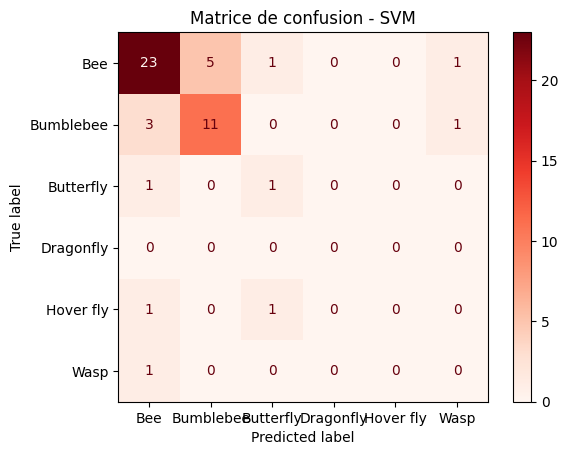

In [ ]:
#===================Matrice d eocnfusion======================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#matrice de confusion 
cm = confusion_matrix(y_test, y_pred, labels=grid_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)

#on plot "
plt.figure(figsize=(8, 6))
disp.plot(cmap="Reds", values_format='d')
plt.title("Matrice de confusion en SVM")
plt.grid(False)
plt.show()

## Deep Learning method with hyperparameters and optimizers

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim

df = pd.read_csv(r"C:\Users\micha\OneDrive\Bureau\IA et OPTI\PROJETIA\features.csv")
np.random.seed(42) #on génère des labels factices aléatoires pour 249 lignes
df["bug_type"] = np.random.choice(["bee", "bumblebee", "other"], size=len(df))

X = df.drop(columns=["img_name", "mask_name", "bug_type"]) # on spéare X et y 
y = df["bug_type"]

scaler = StandardScaler()# normalisation des features
X_scaled = scaler.fit_transform(X)
le = LabelEncoder() # encodage des labels
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split( # on découpe le dataset en train/test
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

#conversion tensors pour PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class SimpleNN(nn.Module): #creation de classe de réseau de neurones simple
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = SimpleNN(X_train.shape[1], len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#on lance l'entrainement 
for epoch in range(30):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

with torch.no_grad(): # rapport évaluation 
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("Classification Report:")
    print(classification_report(y_test_tensor, predicted, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

         bee       0.14      0.19      0.16        16
   bumblebee       0.29      0.25      0.27        16
       other       0.40      0.33      0.36        18

    accuracy                           0.26        50
   macro avg       0.28      0.26      0.26        50
weighted avg       0.28      0.26      0.27        50



# Deep learning methode - Réseau de neurones simple

Plutôt que de travailler directement à partir des images, ont utilise les caractéristiques de l'image (forme, couleur, proportions) afin de limiter la complexité et de rendre le modèle plus léger et rapide à entraîner. Le modèle choisi est un réseau de neurones multicouche simple, entraîné grâce à la bibliothèque PyTorch. Il est composé de deux couches cachées utilisant la fonction d’activation ReLU, ce qui permet de capturer des relations non linéaires entre les différentes caractéristiques. La couche de sortie produit une prédiction parmi les différentes classes de type d’insectes.

L’apprentissage se fait sur des données préalablement normalisées grace à l’optimiseur Adam, qui ajuste les poids du réseau pour minimiser une fonction de perte adaptée à la classification multiclasse. Le réseau est entraîné pendant une trentaine d'epochs, pour ce volume de données c'est suffisant. Plus d'epochs n'aiderai pas.

Les résulatts pour ce modèle atteint une exactitude de 26 %, ce qui reste faible mais cohérent avec la taille limitée du jeu de données et la simplicité du réseau.La classe other est mieux reconnue, f1-score de 0.40, tandis que les classes "bee" et "bumblebee" sont plus difficiles à distinguer. Cela nous montre que le modèle capte certaines différences globales, mais peine à différencier des insectes visuellement proches.